In [1]:
import keras.layers as KL
from keras.models import Model
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import importlib
import config_old
import math
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import plot_model
import utils

importlib.reload(config_old)
importlib.reload(utils)

config = config_old.Config()
image_size = config.image_size[0]
anchor_num = len(config.scales) * len(config.ratios) # 一个锚点对应的anchor数量

dataset = utils.shapeData(config.image_size, config=config) 

Using TensorFlow backend.


In [2]:
class BatchNorm(KL.BatchNormalization):
    def call(self, inputs, training=None):
        return super(self.__class__, self).call(inputs, training=False)

# ResNet网络 的building_block
# filter：卷积核的通道数
# block：block的标识
def building_block(filters, block):
    if block != 0:
        stride = 1
    else:
        stride = 2
    
    def f(x):
        y = KL.Conv2D(filters, (1,1), strides=stride)(x)
        y = BatchNorm(axis=3)(y)
        y = KL.Activation("relu")(y)
        
        y = KL.Conv2D(filters, (3,3), padding="same")(y)
        y = BatchNorm(axis=3)(y)
        y = KL.Activation("relu")(y)
        
        y = KL.Conv2D(4 * filters, (1,1))(y)
        y = BatchNorm(axis=3)(y)
        
        if block == 0:
            # 保证shorcut的filters和上面y的filters个数一致
            shorcut = KL.Conv2D(4 * filters, (1,1), strides=stride)(x)
            shorcut = BatchNorm(axis=3)(shorcut)
        else:
            shorcut = x

        # 结合两个支路的输出
        y = KL.Add()([y, shorcut])
        y = KL.Activation("relu")(y)
        return y
    return f

# ResNet网络
def resNet_featureExtractor(inputs):
    filters = 64   # 第一个卷积核的通道数
    x = KL.Conv2D(filters, (3,3), padding="same")(inputs)
    x = BatchNorm(axis=3)(x)
    x = KL.Activation("relu")(x)

    # resnet50
    blocks = [6, 6, 6]    # buildblock的数量  change
    
    for i, block_num in enumerate(blocks):
        for block_id in range(block_num):
            x = building_block(filters, block_id)(x)
        filters = filters * 2
    return x

def rpn_net(inputs, k):
    shared_map = KL.Conv2D(256, (3,3), padding="same")(inputs)
    shared_map = KL.Activation("linear")(shared_map)
    rpn_class = KL.Conv2D(2 * k, (1,1))(shared_map)
    rpn_class = KL.Lambda(lambda x: tf.reshape(x, [tf.shape(x)[0], -1, 2]))(rpn_class)
    rpn_class = KL.Activation("linear")(rpn_class)
    # 分类的得分
    rpn_prob = KL.Activation("softmax")(rpn_class)
    
    y = KL.Conv2D(4*k, (1,1))(shared_map)
    y = KL.Activation("linear")(y)
    # 边框的得分
    rpn_bbox = KL.Lambda(lambda x: tf.reshape(x, [tf.shape(x)[0], -1, 4]))(y)
    
    return rpn_class, rpn_prob, rpn_bbox

In [3]:
x = KL.Input((config.image_size[0], config.image_size[0], 3))  # change
fp = resNet_featureExtractor(x)
rpn_class, rpn_prob, rpn_bbox = rpn_net(fp, anchor_num)
model = Model([x], [rpn_class, rpn_prob, rpn_bbox])
model.summary()
# plot_model(model, to_file="model/model.png", show_shapes=True)




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_norm_1 (BatchNorm)        (None, 160, 160, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 160, 160, 64) 0           batch_norm_1[0][0]               
__________________________________________________________________________________________________
conv2d_

In [4]:
# x：rpn_box，counts：anchor为1的个数，num_rows = len(counts)：总共多少个
# 小函数，取出rpn_box前面有值的“偏移量”
def batch_back(x, counts, num_rows):
    outputs = []
    for i in range(num_rows):
        outputs.append(x[i, :counts[i]])
    return tf.concat(outputs, axis=0)

# 分类loss
# rpn_match：真实下标  rpn_class_logits：实际计算出的结果
def rpn_class_loss(rpn_match, rpn_class_logits):
    # 压缩最后一维，变成一维的坐标，rpn_match (None, 576, 1) => (None, 576) 
    rpn_match = tf.squeeze(rpn_match, -1)
    # 取出 -1 和 1 的坐标
    indices = tf.where(K.not_equal(rpn_match, 0))
    # 把 -1 和 0 变成 0， 1 还是 1
    anchor_class = K.cast(K.equal(rpn_match, 1), tf.int32)
    # 取出实际计算出的所有-1 和 1坐标的anchor
    rpn_class_logits = tf.gather_nd(rpn_class_logits, indices)     ### prediction
    # 取出真实下标的所有-1 和 1坐标的anchor => 现在是（0, 1）0：表示背景 1：表示前景
    anchor_class = tf.gather_nd(anchor_class, indices)   ### target
    # 计算loss
    loss = K.sparse_categorical_crossentropy(target=anchor_class, output=rpn_class_logits, from_logits=True)
    # 计算平均，如果loss算出东西了，就取平均，如果没算出东西，就取0
    loss = K.switch(tf.size(loss) > 0 , K.mean(loss), tf.constant(0.0))
    return loss

# 回归loss
# target_bbox：真实的边框, rpn_match：真实的anchor下标, rpn_bbox：实际计算出来的结果边框
def rpn_bbox_loss(target_bbox, rpn_match, rpn_bbox):
    # 压缩最后一维，变成一维的坐标，rpn_match (None, 576, 1) => (None, 576) 
    rpn_match = tf.squeeze(rpn_match, -1)
    # 取出 1 的坐标
    indices = tf.where(K.equal(rpn_match, 1))
    # 取出所有 1 的“偏移量”
    rpn_bbox = tf.gather_nd(rpn_bbox, indices)
    # 得出为 1 的“偏移量”的个数
    batch_counts = K.sum(K.cast(K.equal(rpn_match, 1), tf.int32), axis=1)
    # 取出 target_bbox 中为1的“偏移量”
    target_bbox = batch_back(target_bbox, batch_counts, config.batch_size)
    # 求误差
    diff = K.abs(target_bbox - rpn_bbox)
    # 取出小于1的部分
    less_than_one = K.cast(K.less(diff, 1.0), "float32")
    # 小于1的部分给抛物线  diff**2
    # 大于1的部分给直线（不会对大的误差敏感） diff-0.5
    loss = (less_than_one * 0.5 * diff**2) + ((1 - less_than_one) * (diff - 0.5))
    # 计算平均，如果loss算出东西了，就取平均，如果没算出东西，就取0
    loss = K.switch(tf.size(loss) > 0 , K.mean(loss), tf.constant(0.0))
    return loss

# 图片的输入
input_image = KL.Input(shape=[config.image_size[0], config.image_size[0],3], dtype=tf.float32)  # change
# 真实的边框输入
input_bboxes = KL.Input(shape=[None, 4], dtype=tf.float32)
# 真实的分类输入
input_class_ids = KL.Input(shape=[None], dtype=tf.int32)
# 真实的anchor分类 -1,0,1输入
input_rpn_match = KL.Input(shape=[None, 1], dtype=tf.int32)
# 真实的anchor偏移量输入
input_rpn_bbox = KL.Input(shape=[None, 4], dtype=tf.float32)


# 创建模型
feature_map = resNet_featureExtractor(input_image)
# 模型计算出的结果 rpn_class，rpn_prob，rpn_bbox
rpn_class, rpn_prob, rpn_bbox = rpn_net(feature_map, anchor_num)
# 分类loss
loss_rpn_match = KL.Lambda(lambda x: rpn_class_loss(*x), name="loss_rpn_match")(
    [input_rpn_match, rpn_class]
)
loss_rpn_bbox = KL.Lambda(lambda x:rpn_bbox_loss(*x), name="loss_rpn_bbox")(
    [input_rpn_bbox, input_rpn_match, rpn_bbox]
)
model = Model(
    [input_image, input_bboxes, input_class_ids, input_rpn_match, input_rpn_bbox],
    [rpn_class, rpn_prob, rpn_bbox, loss_rpn_match, loss_rpn_bbox]
)
# 添加loss层
loss_lay1 = model.get_layer("loss_rpn_match").output
loss_lay2 = model.get_layer("loss_rpn_bbox").output
model.add_loss(tf.reduce_mean(loss_lay1))
model.add_loss(tf.reduce_mean(loss_lay2))
# 编译
model.compile(loss = [None] * len(model.output), optimizer=keras.optimizers.SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False))
# 打印出两个loss的收敛情况
model.metrics_names.append("loss_rpn_match")
model.metrics_tensors.append(tf.reduce_mean(loss_lay1, keep_dims=True))
model.metrics_names.append("loss_rpn_bbox")
model.metrics_tensors.append(tf.reduce_mean(loss_lay2, keep_dims=True))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [5]:
def data_Gen(num_batch, batch_size, config):
    print("----------------")
    for iii in range(num_batch):
        images = []
        bboxes = []
        class_ids = []
        rpn_matchs = []
        rpn_bboxes = []
        for i in range(batch_size):
            image, bbox, class_id, rpn_match, rpn_bbox, _ = data = dataset.load_data()
            pad_num = config.max_gt_obj - bbox.shape[0]
            pad_box = np.zeros((pad_num, 4))
            pad_ids = np.zeros((pad_num, 1))
            bbox = np.concatenate([bbox, pad_box], axis=0)
            class_id = np.concatenate([class_id, pad_ids], axis=0)
        
            images.append(image)
            bboxes.append(bbox)
            class_ids.append(class_id)
            rpn_matchs.append(rpn_match)
            rpn_bboxes.append(rpn_bbox)

#         print("数据：" + str(index))
        images = np.concatenate(images, 0).reshape(batch_size, config.image_size[0],config.image_size[1] , 3)
        bboxes = np.concatenate(bboxes, 0).reshape(batch_size, -1 , 4)
        class_ids = np.concatenate(class_ids, 0).reshape(batch_size, -1 )
        rpn_matchs = np.concatenate(rpn_matchs, 0).reshape(batch_size, -1 , 1)
        rpn_bboxes = np.concatenate(rpn_bboxes, 0).reshape(batch_size, -1 , 4)
        yield [images, bboxes, class_ids, rpn_matchs, rpn_bboxes],[]

total = 200000          # 总数据
steps_per_epoch = 20   # 步长
dataGen = data_Gen(int(total), config.batch_size, config) # 10000个数据，batch_size=10

In [6]:
# face V2版本
# 参数1320万 320 × 320  batch_size：10 steps_per_epoch：20  rpn_stride：16  scales：[55, 60, 70, 85, 105, 140, 180, 230]  buildblock：[7,7,7]   文件名：model_224_16_[epochs数]_v2.h5
# 第一次20epochs lr=0.0001 batch_size：10  1w数据
# drop = 0.5 衰减率调小
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print('学习率：' + str(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)
his = model.fit_generator(dataGen, steps_per_epoch=steps_per_epoch, epochs=200, callbacks=[lrate])  



----------------Epoch 1/200

学习率：0.0001
20/20 [==============================] - 279s 14s/step - loss: 6.2875 - loss_rpn_match: 2.2953 - loss_rpn_bbox: 3.9922
Epoch 2/200
学习率：0.0001
20/20 [==============================] - 294s 15s/step - loss: 0.8813 - loss_rpn_match: 0.4107 - loss_rpn_bbox: 0.4705
Epoch 3/200
学习率：0.0001
20/20 [==============================] - 273s 14s/step - loss: 0.6454 - loss_rpn_match: 0.2753 - loss_rpn_bbox: 0.3702
Epoch 4/200
学习率：0.0001
20/20 [==============================] - 296s 15s/step - loss: 0.6039 - loss_rpn_match: 0.2561 - loss_rpn_bbox: 0.3478
Epoch 5/200
学习率：0.0001
20/20 [==============================] - 290s 15s/step - loss: 0.5749 - loss_rpn_match: 0.2414 - loss_rpn_bbox: 0.3334
Epoch 6/200
学习率：0.0001
20/20 [==============================] - 287s 14s/step - loss: 0.5821 - loss_rpn_match: 0.2436 - loss_rpn_bbox: 0.3385
Epoch 7/200
学习率：0.0001
20/20 [==============================] - 319s 16s/step - loss: 0.5788 - loss_rpn_match: 0.2396 - loss_rpn_

20/20 [==============================] - 261s 13s/step - loss: 0.5352 - loss_rpn_match: 0.2232 - loss_rpn_bbox: 0.3120
Epoch 56/200
学习率：3.125e-06
20/20 [==============================] - 260s 13s/step - loss: 0.5302 - loss_rpn_match: 0.2193 - loss_rpn_bbox: 0.3109
Epoch 57/200
学习率：3.125e-06
20/20 [==============================] - 262s 13s/step - loss: 0.5318 - loss_rpn_match: 0.2221 - loss_rpn_bbox: 0.3097
Epoch 58/200
学习率：3.125e-06
20/20 [==============================] - 263s 13s/step - loss: 0.5244 - loss_rpn_match: 0.2175 - loss_rpn_bbox: 0.3069
Epoch 59/200
学习率：3.125e-06
20/20 [==============================] - 259s 13s/step - loss: 0.5289 - loss_rpn_match: 0.2184 - loss_rpn_bbox: 0.3106
Epoch 60/200
学习率：1.5625e-06
20/20 [==============================] - 260s 13s/step - loss: 0.5255 - loss_rpn_match: 0.2204 - loss_rpn_bbox: 0.3052
Epoch 61/200
学习率：1.5625e-06
20/20 [==============================] - 261s 13s/step - loss: 0.5445 - loss_rpn_match: 0.2311 - loss_rpn_bbox: 0.3134
Epo

20/20 [==============================] - 259s 13s/step - loss: 0.5346 - loss_rpn_match: 0.2234 - loss_rpn_bbox: 0.3113
Epoch 111/200
学习率：4.8828125e-08
20/20 [==============================] - 259s 13s/step - loss: 0.5302 - loss_rpn_match: 0.2233 - loss_rpn_bbox: 0.3069
Epoch 112/200
学习率：4.8828125e-08
20/20 [==============================] - 261s 13s/step - loss: 0.5322 - loss_rpn_match: 0.2230 - loss_rpn_bbox: 0.3093
Epoch 113/200
学习率：4.8828125e-08
20/20 [==============================] - 258s 13s/step - loss: 0.5388 - loss_rpn_match: 0.2302 - loss_rpn_bbox: 0.3086
Epoch 114/200
学习率：4.8828125e-08
20/20 [==============================] - 260s 13s/step - loss: 0.5363 - loss_rpn_match: 0.2234 - loss_rpn_bbox: 0.3129
Epoch 115/200
学习率：4.8828125e-08
20/20 [==============================] - 260s 13s/step - loss: 0.5409 - loss_rpn_match: 0.2234 - loss_rpn_bbox: 0.3175
Epoch 116/200
学习率：4.8828125e-08
20/20 [==============================] - 257s 13s/step - loss: 0.5337 - loss_rpn_match: 0.2227

20/20 [==============================] - 259s 13s/step - loss: 0.5334 - loss_rpn_match: 0.2216 - loss_rpn_bbox: 0.3118
Epoch 164/200
学习率：1.52587890625e-09
20/20 [==============================] - 261s 13s/step - loss: 0.5363 - loss_rpn_match: 0.2254 - loss_rpn_bbox: 0.3109
Epoch 165/200
学习率：1.52587890625e-09
20/20 [==============================] - 259s 13s/step - loss: 0.5261 - loss_rpn_match: 0.2169 - loss_rpn_bbox: 0.3092
Epoch 166/200
学习率：1.52587890625e-09
20/20 [==============================] - 258s 13s/step - loss: 0.5358 - loss_rpn_match: 0.2217 - loss_rpn_bbox: 0.3141
Epoch 167/200
学习率：1.52587890625e-09
20/20 [==============================] - 259s 13s/step - loss: 0.5281 - loss_rpn_match: 0.2202 - loss_rpn_bbox: 0.3079
Epoch 168/200
学习率：1.52587890625e-09
20/20 [==============================] - 259s 13s/step - loss: 0.5229 - loss_rpn_match: 0.2165 - loss_rpn_bbox: 0.3064
Epoch 169/200
学习率：1.52587890625e-09
20/20 [==============================] - 260s 13s/step - loss: 0.5323 

In [55]:
# model.save_weights("model_material_64_200.h5")
model.load_weights("model_material_64_200.h5")
# model.save_weights("model_material_160_200.h5")
# model.load_weights("model_material1.h5")

OSError: Unable to open file (unable to open file: name = 'model_material_64_200.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [56]:
# 将anchors根据计算出的修正量逆运算出实际计算的anchors
# anchors：锚框
# deltas：网络计算出的修正量
def anchor_refinement(anchors, deltas):
    boxes = tf.cast(anchors, tf.float32)
    h = boxes[:, 2] - boxes[:, 0]
    w = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + h / 2
    center_x = boxes[:, 1] + w / 2

    center_y += deltas[:, 0] * h
    center_x += deltas[:, 1] * w
    h *= tf.exp(deltas[:, 2])
    w *= tf.exp(deltas[:, 3])
    
    y1 = center_y - h / 2
    x1 = center_x - w / 2
    y2 = center_y + h / 2
    x2 = center_x + w / 2
    boxes = tf.stack([y1, x1, y2, x2], axis=1)
    return boxes

# 限定坐标的边界，不超过边界
def boxes_clip(boxes, window):
    wy1, wx1, wy2, wx2 = tf.split(window, 4)
    y1, x1, y2, x2 = tf.split(boxes, 4, axis=1)
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    cliped = tf.concat([y1, x1, y2, x2], axis=1)
    cliped.set_shape((cliped.shape[0], 4))
    return cliped

# 将输入的inputs 按提供的 graph_fn方法进行切片
# 因为数据是batch_size个的数组，所以这个函数是进行batch_size个数组的操作
def batch_slice(inputs, graph_fn, batch_size):
    if not isinstance(inputs, list):
        inputs = [inputs]
    output = []
    for i in range(batch_size):
        inputs_slice = [x[i] for x in inputs]
        output_slice = graph_fn(*inputs_slice)
        if not isinstance(output_slice, (list, tuple)):
            output_slice = [output_slice]
        output.append(output_slice)
    # 打包输出出去
    output = list(zip(*output))
    result = [tf.stack(o, axis=0) for o in output]
    if len(result)==1:
        result = result[0]
    return result


import keras.engine as KE
class proposal(KE.Layer):
    # proposal_count：保留的框个数
    # nms_thresh：超过这个阈值，两个anchor就去pk
    # anchors：锚框
    # batch_size
    # config：配置项
    # kwargs：其他参数
    def __init__(self, proposal_count, nms_thresh, anchors, batch_size, config=None, **kwargs):
        super(proposal, self).__init__(**kwargs)
        self.proposal_count = proposal_count
        self.anchors = anchors
        self.nms_thresh = nms_thresh
        self.batch_size = batch_size
        self.config = config
    
    # input：输入的 probs置信度inputs[0] 和 deltas修正量inputs[1]
    def call(self, inputs):
        # 取最后一维（前景概率）
        probs = inputs[0][:, :, 1]
        # 修正量
        deltas = inputs[1]
        # -------------------------------- 取得分前100的锚框数据 --------------------------------
        # 乘RPN_BBOX_STD_DEV，是因为build_rpnTarget函数里面除以了这个数，避免值太小
        deltas = deltas * np.reshape(self.config.RPN_BBOX_STD_DEV, (1, 1, 4))
        # 判断：取100和anchors数之间最小
        prenms_num = min(100, self.anchors.shape[0])
        # 取前100个锚框得分最高的锚框下标
        idxs = tf.nn.top_k(probs, prenms_num).indices
        
        # 按坐标取元素
        # 置信度
        probs = batch_slice([probs, idxs], lambda x,y:tf.gather(x, y), self.batch_size)
        # 修正量
        deltas = batch_slice([deltas, idxs], lambda x,y:tf.gather(x, y), self.batch_size)
        # 锚框
        anchors = batch_slice([idxs], lambda x:tf.gather(self.anchors,x), self.batch_size)

        # ----------------------------------------- 修正 -----------------------------------------
        # 取修正框
        refined_boxes = batch_slice([anchors, deltas], lambda x,y:anchor_refinement(x,y), self.batch_size)
        # 限定坐标的边界，不超过边界，避免修到外面去
        H,W = self.config.image_size[:2]
        windows = np.array([0,0,H,W]).astype(np.float32)
        cliped_boxes = batch_slice([refined_boxes], lambda x:boxes_clip(x, windows), self.batch_size)
        
        # 归一化
        normalized_boxes = cliped_boxes / np.array([H,W,H,W])
        # 非极大值抑制方法
        def nms(normalized_boxes, scores):
            idxs_ = tf.image.non_max_suppression(normalized_boxes, scores, self.proposal_count, self.nms_thresh)
            box = tf.gather(normalized_boxes, idxs_)
            pad_num = tf.maximum(self.proposal_count - tf.shape(normalized_boxes)[0],0)
            box = tf.pad(box, [(0,pad_num),(0,0)])
            return box
        # 进行非极大值抑制切换
        proposal_ = batch_slice([normalized_boxes, probs], nms, self.batch_size)
        return proposal_
    
    def compute_output_shape(self, input_shape):
        return (None, self.proposal_count, 4)

In [57]:
test_data = next(dataGen)[0]
images = test_data[0]
bboxes = test_data[1]
class_ids = test_data[2]
rpn_matchs = test_data[3]
rpn_bboxes = test_data[4]
print(images.shape)
rpn_class, rpn_prob, rpn_bbox, _, _ = \
                model.predict([images, bboxes, class_ids, rpn_matchs, rpn_bboxes])
# 转tensor
rpn_class = tf.convert_to_tensor(rpn_class)
rpn_prob = tf.convert_to_tensor(rpn_prob)
rpn_bbox = tf.convert_to_tensor(rpn_bbox)

(15, 160, 160, 3)


In [58]:
# import utils
# change
anchors = utils.anchor_gen(config.featureMap_size, ratios=config.ratios, scales=config.scales, rpn_stride=config.rpn_stride,
                           anchor_stride = config.anchor_stride)
proposals = proposal(proposal_count=15, nms_thresh=0.7, anchors=anchors, batch_size=config.batch_size, config=config)([rpn_prob, rpn_bbox])

In [59]:
sess = tf.Session()
proposals_ = sess.run(proposals) * image_size # change

In [81]:
import random

# ix = 2
ix = random.sample(range(config.batch_size), 1)[0]
proposal_ = proposals_[ix]
img = images[ix]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 88.22589     0.        120.78874    24.327328 ]
 [ 88.854324   39.48102   121.2169     71.62369  ]
 [117.997284    1.2314062 152.48703    32.90473  ]
 [ 56.187523    0.         88.72766    18.091991 ]
 [ 88.11301    30.67647   121.97856    64.76978  ]
 [ 54.091255   24.345097   91.00427    54.309982 ]
 [  1.6411457 122.68082    29.641134  146.93152  ]
 [ 87.48834    23.67511   122.63051    55.749107 ]
 [ 86.818726    0.        123.258835   33.175278 ]
 [ 88.484116   62.883553  120.81601    96.43243  ]
 [ 85.98894     6.8491764 122.128815   40.512985 ]
 [ 56.08635    31.217527   88.63289    62.953186 ]
 [ 78.101654  134.02054   110.45192   160.       ]
 [121.29146     0.        152.19926    25.433083 ]
 [ 43.812733   43.293144   68.16989    66.592094 ]]


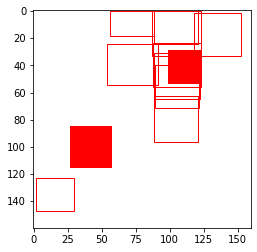

In [82]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

plt.imshow(img)
axs = plt.gca()
print(proposal_)
for i in range(10):
    box = proposal_[i]
    rec = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor='none', edgecolor='r')
    axs.add_patch(rec)